In [4]:
import requests
result = requests.get("http://cat-fact.herokuapp.com/facts/random")
print(result)
print(result.json())
print(result.json()['text'])

<Response [200]>
{'used': False, 'source': 'api', 'type': 'cat', 'deleted': False, '_id': '591f9894d369931519ce358b', '__v': 0, 'text': 'Cats lose almost as much fluid in the saliva while grooming themselves as they do through urination.', 'updatedAt': '2020-08-23T20:20:01.611Z', 'createdAt': '2018-04-26T20:20:02.740Z', 'status': {'verified': True, 'sentCount': 1}, 'user': '5a9ac18c7478810ea6c06381'}
Cats lose almost as much fluid in the saliva while grooming themselves as they do through urination.


In [6]:
import requests
result = requests.get("http://3.14.81.252:5000/?msg=HelloWorld!")
print(result.json())

{'response': 'HelloWorld!', 'success': True}


In [10]:
result = requests.get("http://3.14.81.252:5000/",params={"msg":"Hello from params"})
print(result.json())

{'response': 'HelloWorld!', 'success': True}


In [25]:
result = requests.post("http://3.14.81.252:5000/",params={"msg":"Hello from data"})
print(result.json())

{'response': 'Hello from data', 'success': True}


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64

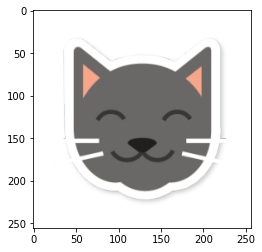

In [27]:
image = open("luna.png","rb").read()
encoded = base64.b64encode(image)
result = requests.post("http://3.14.81.252:5000/",
                    params={'msg':encoded})
encoded = result.json()['response']
imgData = base64.b64decode(encoded)
plt.imshow(np.array(Image.open(io.BytesIO(imgData))))